Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


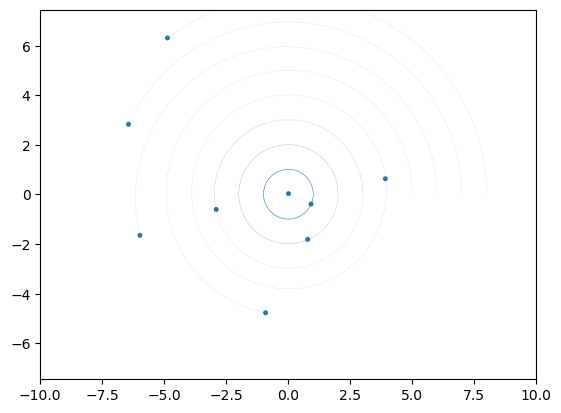

In [2]:
# ================================================================================
# ANIMACION SISTEMA SOLAR
#
# Genera una animación a partir de un fichero de datos con las posiciones
# de los planetas en diferentes instantes de tiempo.
# 
# El fichero debe estructurarse de la siguiente forma:
# 
#   x1_1, y1_1
#   x2_1, y2_1
#   x3_1, y3_1
#   (...)
#   xN_1, yN_1
#   
#   x1_2, y1_2
#   x2_2, y2_2
#   x3_2, y3_2
#   (...)
#   xN_2, yN_2
#
#   x1_3, y1_3
#   x2_3, y2_3
#   x3_3, y3_3
#   (...)
#   xN_3, yN_3
#   
#   (...)
#
# donde xi_j es la componente x del planeta i-ésimo en el instante de
# tiempo j-ésimo, e yi_j lo mismo en la componente y. El programa asume que
# el nº de planetas es siempre el mismo.
# ¡OJO! Los datos están separados por comas.
# 
# Si solo se especifica un instante de tiempo, se genera una imagen en pdf
# en lugar de una animación
#
# Se puede configurar la animación cambiando el valor de las variables
# de la sección "Parámetros"
#
# ================================================================================

# Importa los módulos necesarios
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import numpy as np

# Parámetros
# ========================================
file_in = "C:/Users/garci/projects/Compu/FisiCompis/planets_data.dat" # Nombre del fichero de datos
file_out = "C:/Users/garci/projects/Compu/FisiCompis/planetas" # Nombre del fichero de salida (sin extensión)

# Límites de los ejes X e Y
x_min = -10
x_max = 10
y_min = -10
y_max = 10

interval = 50 # Tiempo entre fotogramas en milisegundos
show_trail = True # Muestra la "estela" del planeta
trail_width = 0.05 # Ancho de la estela
save_to_file = True # False: muestra la animación por pantalla,
                     # True: la guarda en un fichero
dpi = 300 # Calidad del vídeo de salida (dots per inch)

# Radio del planeta, en las mismas unidades que la posición
# Puede ser un número (el radio de todos los planetas) o una lista con
# el radio de cada uno
planet_radius = 0.1

"""planet_radius = [
    1.5,    # Sol (fijo)
    0.3793, # Mercurio
    0.3856, # Venus
    0.3862, # Tierra
    0.3810, # Marte
    0.5,    # Júpiter (fijo)
    0.4803, # Saturno
    0.4197, # Urano
    0.4184, # Neptuno
]
"""


# Lectura del fichero de datos
# ========================================
# Lee el fichero a una cadena de texto
with open(file_in, "r") as f:
    data_str = f.read()

# Inicializa la lista con los datos de cada fotograma.
# frames_data[j] contiene los datos del fotograma j-ésimo
frames_data = list()

# Itera sobre los bloques de texto separados por líneas vacías
# (cada bloque corresponde a un instante de tiempo)
for frame_data_str in data_str.split("\n\n"):
    # Inicializa la lista con la posición de cada planeta
    frame_data = list()

    # Itera sobre las líneas del bloque
    # (cada línea da la posición de un planta)
    for planet_pos_str in frame_data_str.split("\n"):
        # Lee la componente x e y de la línea
        planet_pos = np.fromstring(planet_pos_str, sep=",")
        # Si la línea no está vacía, añade planet_pos a la lista de 
        # posiciones del fotograma
        if planet_pos.size > 0:
            frame_data.append(np.fromstring(planet_pos_str, sep=","))

    # Añade los datos de este fotograma a la lista
    frames_data.append(frame_data)

# El número de planetas es el número de líneas en cada bloque
# Lo calculamos del primer bloque
nplanets = len(frames_data[0])


# Creación de la animación/gráfico
# ========================================
# Crea los objetos figure y axis
fig, ax = plt.subplots()

# Define el rango de los ejes
ax.axis("equal")  # Misma escala para ejes X e Y
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Si solo se ha dado un radio para todos los planetas, conviértelo a una
# lista con todos los elementos iguales
if not hasattr(planet_radius, "__iter__"):
    planet_radius = planet_radius*np.ones(nplanets)
# En caso contrario, comprueba que el nº de radios coincide con el
# nº de planetas y devuelve error en caso contrario
else:
    if not nplanets == len(planet_radius):
        raise ValueError(
                "El número de radios especificados no coincide con el número "
                "de planetas")

# Representa el primer fotograma
# Pinta un punto en la posición de cada paneta y guarda el objeto asociado
# al punto en una lista
planet_points = list()
planet_trails = list()
for planet_pos, radius in zip(frames_data[0], planet_radius):
    x, y = planet_pos
    #planet_point, = ax.plot(x, y, "o", markersize=10)
    planet_point = Circle((x, y), radius)
    ax.add_artist(planet_point)
    planet_points.append(planet_point)

    # Inicializa las estelas (si especificado en los parámetros)
    if show_trail:
        planet_trail, = ax.plot(
                x, y, "-", linewidth=trail_width,
                color=planet_points[-1].get_facecolor())
        planet_trails.append(planet_trail)
 
# Función que actualiza la posición de los planetas en la animación 
def update(j_frame, frames_data, planet_points, planet_trails, show_trail):
    # Actualiza la posición del correspondiente a cada planeta
    for j_planet, planet_pos in enumerate(frames_data[j_frame]):
        x, y = planet_pos
        planet_points[j_planet].center = (x, y)

        if show_trail:
            xs_old, ys_old = planet_trails[j_planet].get_data()
            xs_new = np.append(xs_old, x)
            ys_new = np.append(ys_old, y)

            planet_trails[j_planet].set_data(xs_new, ys_new)

    return planet_points + planet_trails

def init_anim():
    # Clear trails
    if show_trail:
        for j_planet in range(nplanets):
            planet_trails[j_planet].set_data(list(), list())

    return planet_points + planet_trails

# Calcula el nº de frames
nframes = len(frames_data)

# Si hay más de un instante de tiempo, genera la animación
if nframes > 1:
    # Info sobre FuncAnimation: https://matplotlib.org/stable/api/animation_api.html
    animation = FuncAnimation(
            fig, update, init_func=init_anim,
            fargs=(frames_data, planet_points, planet_trails, show_trail),
            frames=len(frames_data), blit=True, interval=interval)

    # Muestra por pantalla o guarda según parámetros
    if save_to_file:
        animation.save("{}.mp4".format(file_out), dpi=dpi)
    else:
        plt.show()
# En caso contrario, muestra o guarda una imagen
else:
    # Muestra por pantalla o guarda según parámetros
    if save_to_file:
        fig.savefig("{}.pdf".format(file_out))
    else:
        plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\garci\AppData\Local\Temp\ipykernel_13496\1318643876.py (58)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_13496\1318643876.py", line 58:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m 

This error may have been caused by the following argument(s):
- argument 1: Cannot type list element type <class 'matplotlib.patches.Circle'>
- argument 2: Cannot type list element type <class 'matplotlib.lines.Line2D'>


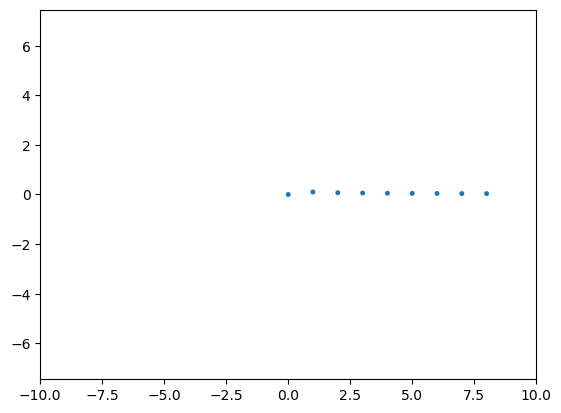

In [ ]:
import numpy as np
from numba import njit
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

# -------------------------------------------------------------------------
# PARTE 1: Parámetros generales
# -------------------------------------------------------------------------
file_in = "C:/Users/garci/projects/Compu/FisiCompis/planets_data.dat"
file_out = "C:/Users/garci/projects/Compu/FisiCompis/planetas"

x_min, x_max = -10, 10
y_min, y_max = -10, 10

interval = 50          # milisegundos entre fotogramas
show_trail = True      # mostrar estela
trail_width = 0.05
save_to_file = True
dpi = 300

planet_radius = 0.1    # radio (misma unidad que las posiciones)

# -------------------------------------------------------------------------
# PARTE 2: Lectura del fichero de datos y conversión a NumPy
# -------------------------------------------------------------------------
with open(file_in, "r") as f:
    data_str = f.read()

# 'frames_data' será una lista de fotogramas (cada fotograma es una lista 
# con las posiciones [x, y] de cada planeta).
frames_data_list = []
for frame_data_str in data_str.strip().split("\n\n"):
    if frame_data_str.strip():
        frame_data = []
        for planet_pos_str in frame_data_str.split("\n"):
            planet_pos = np.fromstring(planet_pos_str, sep=",")
            if planet_pos.size == 2:
                frame_data.append(planet_pos)
        frames_data_list.append(frame_data)

nframes = len(frames_data_list)
nplanets = len(frames_data_list[0])

# Convierto 'frames_data_list' en un array 3D de NumPy (forma: [nframes, nplanets, 2])
@njit
def list_to_3darray(frames_list):
    """
    Convierte una lista de fotogramas (cada fotograma es lista de [x,y]) 
    en un array NumPy de dimensiones (nframes, nplanets, 2).
    """
    n_frames = len(frames_list)
    n_planets = len(frames_list[0])
    out = np.zeros((n_frames, n_planets, 2), dtype=np.float64)
    for i in range(n_frames):
        for j in range(n_planets):
            out[i, j, 0] = frames_list[i][j][0]
            out[i, j, 1] = frames_list[i][j][1]
    return out

frames_data_np = list_to_3darray(frames_data_list)

# -------------------------------------------------------------------------
# PARTE 3: Configuración de la ventana gráfica y creación de objetos
# -------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")  # mantiene la misma escala en X e Y
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Ajustamos 'planet_radius' para que sea un array (si se pasó un escalar).
if not hasattr(planet_radius, "__iter__"):
    planet_radius = planet_radius * np.ones(nplanets)
elif len(planet_radius) != nplanets:
    raise ValueError("El número de radios especificados no coincide con el número de planetas.")

# Creamos las listas para “Circle” (planetas) y las líneas (trails)
planet_points = []
planet_trails = []
for i_planet in range(nplanets):
    x0, y0 = frames_data_np[0, i_planet, 0], frames_data_np[0, i_planet, 1]
    r = planet_radius[i_planet]
    
    # El "patch" Circle que representa el planeta
    planet = Circle((x0, y0), r)
    ax.add_artist(planet)
    planet_points.append(planet)

    # La estela (línea) para ese planeta
    if show_trail:
        trail_line, = ax.plot([x0], [y0], "-", linewidth=trail_width,
                              color=planet.get_facecolor())
        planet_trails.append(trail_line)

# -------------------------------------------------------------------------
# PARTE 4: Funciones de animación
# -------------------------------------------------------------------------
def init_anim():
    # Limpia las estelas en caso de que show_trail=True
    if show_trail:
        for tr in planet_trails:
            tr.set_data([], [])
    return planet_points + planet_trails

def update(frame_idx):
    """
    Esta función se llama en cada fotograma. Toma la posición de cada planeta 
    del array frames_data_np y actualiza las coordenadas en el objeto Circle.
    Luego, si show_trail es True, añade (x,y) al rastro de cada planeta.
    """
    # Recuperamos las posiciones para este fotograma
    # (no hace nada complejo, pero aquí es donde podría llamarse a numba 
    #  si hubiese un cálculo caro que hacer).
    positions = frames_data_np[frame_idx]

    # Actualiza la parte gráfica en Python “normal”
    for i_planet in range(nplanets):
        x, y = positions[i_planet]
        
        # Mover el Circle a la nueva posición
        planet_points[i_planet].center = (x, y)
        
        # Agregar el nuevo punto a la estela
        if show_trail:
            xs_old, ys_old = planet_trails[i_planet].get_data()
            xs_new = np.append(xs_old, x)
            ys_new = np.append(ys_old, y)
            planet_trails[i_planet].set_data(xs_new, ys_new)

    # Devuelve la lista de artistas para permitir blitting
    return planet_points + planet_trails

# -------------------------------------------------------------------------
# PARTE 5: Crear la animación
# -------------------------------------------------------------------------
if nframes > 1:
    animation = FuncAnimation(
        fig=fig, func=update, init_func=init_anim,
        frames=nframes, interval=interval, blit=True
    )

    if save_to_file:
        animation.save(f"{file_out}.mp4", dpi=dpi)
    else:
        plt.show()

else:
    # Si solo hay 1 fotograma, dibujamos la figura estática
    if save_to_file:
        fig.savefig(f"{file_out}.pdf", dpi=dpi)
    else:
        plt.show()
